# DQN Project Part 3

Code runs through until completion

## Contributors: 
- Tadhg Ryan (21310408)
- Craig Phayer (21340633)
- Thomas McCarty (21327696)


In [ ]:
# Installs

# %pip install --upgrade pip
# %pip install -q -U gymnasium swig
# %pip install gymnasium[atari]==0.29.1
# %pip install gymnasium[classic_control,box2d,accept-rom-license,ActionWrapper]==0.29.1
# %pip install tensorflow==2.10
# %pip install "numpy<2"
# %pip install matplotlib
# %pip install opencv-python
# %pip install moviepy


In [1]:
# Imports

import tensorflow as tf
import numpy as np
import gymnasium as gym
import cv2
from collections import deque
import os
from tensorflow.keras import layers, models
import random
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from tensorflow.keras.models import load_model
from gymnasium.core import Wrapper
import matplotlib.pyplot as plt


In [2]:
# Show Hardware

tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs available:")
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("Name:", details.get('device_name', 'Unknown GPU'))
else:
    print("No GPU available.")

print(tf.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


Num GPUs Available:  1
GPUs available:
Name: NVIDIA GeForce RTX 4060
2.10.0


In [3]:
# Make Env

env = gym.make("ALE/Qbert-v5", obs_type="ram", frameskip=4, render_mode="rgb_array")
env.reset(seed=42)

print("Action space:", env.action_space)
print("Observation space:", env.observation_space)


Action space: Discrete(6)
Observation space: Box(0, 255, (128,), uint8)


In [4]:
# Env Functions

frame_stack = deque(maxlen=4)

def reset_env_with_stack(env):
    state, info = env.reset(seed=42)
    for _ in range(4):
        frame_stack.append(state)
    return np.stack(frame_stack, axis=-1), info

def step_env_with_stack(env, action):
    next_state, reward, done, truncated, info = env.step(action)
    frame_stack.append(state)
    return np.stack(frame_stack, axis=-1), reward, done, truncated, info

state, _ = env.reset(seed=42)
print("Processed frame shape:", state.shape)

Processed frame shape: (128,)


In [5]:
# Create Model

def create_dqn(action_space):
    model = models.Sequential([
        layers.Input(shape=(128, 4)),
        layers.Flatten(),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(action_space, activation='linear')
    ])
    return model

# Initialize the model
dqn_model = create_dqn(env.action_space.n)
dqn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 512)               2

In [6]:
# Replay Buffer

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, epsilon=1e-6):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon

        self.buffer = []
        
        self.priorities = []
        
        self.size = 0
        self.idx = 0
    
    def add(self, experience):
        if self.size < self.capacity:
            self.buffer.append(experience)
            self.priorities.append(max(self.priorities, default=1.0))
            self.size += 1
        else:
            self.buffer[self.idx] = experience
            self.priorities[self.idx] = max(self.priorities, default=1.0)
        self.idx = (self.idx + 1) % self.capacity

    def sample(self, batch_size):
        priorities = np.array(self.priorities) ** self.alpha
        sampling_probs = priorities / sum(priorities)

        indices = np.random.choice(np.arange(self.size), size=batch_size, p=sampling_probs)
        
        experiences = [self.buffer[idx] for idx in indices]
        weights = (self.size * sampling_probs[indices]) ** -self.beta
        weights = weights / weights.max()

        return experiences, weights, indices

    def update_priorities(self, indices, errors):
        for idx, error in zip(indices, errors):
            self.priorities[idx] = (abs(error) + self.epsilon) ** self.alpha

    def size(self):
        return self.size

replay_buffer = PrioritizedReplayBuffer(capacity=15_000_000)

In [7]:
# Select Action

def select_action(model, state, epsilon, action_space):
    if random.random() < epsilon:
        return random.randint(0, action_space - 1)
    else:
        q_values = model.predict(state[None, ...], verbose=0)
        return np.argmax(q_values)

In [8]:
# Reward Function

class CustomRewardWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)

        reward = self.custom_reward_function(reward, info)

        return state, reward, done, truncated, info

    @staticmethod
    def custom_reward_function(reward, info):
        adjusted_reward = reward

        if "lives" in info and info["lives"] < 4:
            adjusted_reward -= 50 * (4 - info["lives"])

        if reward > 0:
            adjusted_reward += 25

        if "cube_color_changed" in info:
            adjusted_reward += 10 

        if "cube_destination_reached" in info:
            adjusted_reward += 50

        if "cube_reverted" in info:
            adjusted_reward -= 15

        if "level_completed" in info:
            adjusted_reward += 1000
            adjusted_reward += max(0, 200 - info.get("steps", 0))

        if "avoided_enemy" in info:
            adjusted_reward += 10

        if "caught_green_ball" in info:
            adjusted_reward += 50

        if "coily_defeated" in info:
            adjusted_reward += 100

        if info.get("no_op", False) or info.get("fire", False):
            adjusted_reward -= 1

        scaling_factor = info.get("episode", 0) / 100
        adjusted_reward += scaling_factor * adjusted_reward

        return adjusted_reward

env = CustomRewardWrapper(env)

In [9]:
# Train DQN

def soft_decay_interpolation(t, a, b, k=10):
    return b - (b - a) / (1.0 + np.exp(k * (t - 0.5)))

def train_dqn(env, model, target_model, replay_buffer, episodes=500, batch_size=32, gamma=0.99, epsilon_min=0.1, epsilon_max=1, update_target=10, verbose=0):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss_fn = tf.keras.losses.Huber()
    rewards_history = []
    epsilon = epsilon_max

    for episode in range(episodes):
        state, _ = reset_env_with_stack(env)
        total_reward = 0
        episode_loss = 0
        total_lives = 4

        epsilon_reward = epsilon * 50

        for step in range(10_000):
            action = select_action(model, state, epsilon, env.action_space.n)
            next_state, reward, done, truncated, info = step_env_with_stack(env, action)

            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if step == 0:
                reward += epsilon_reward

            if replay_buffer.size > batch_size:
                experiences, weights, indices = replay_buffer.sample(batch_size=batch_size)

                states, actions, rewards, next_states, dones = zip(*experiences)
                rewards = np.array(rewards)
                dones = np.array(dones)
                states = np.array(states)
                states = states.reshape(batch_size, 128, 4)
                next_states = np.array(next_states)
                next_states = next_states.reshape(batch_size, 128, 4)

                next_q_actions = np.argmax(model.predict(next_states, verbose=verbose), axis=1)
                next_q_values = target_model.predict(next_states, verbose=verbose)
                target_q_values = rewards + gamma * next_q_values[np.arange(batch_size), next_q_actions] * (1 - dones)

                with tf.GradientTape() as tape:
                    q_values = model(states)
                    q_values = tf.reduce_sum(q_values * tf.one_hot(actions, env.action_space.n), axis=1)
                    loss = loss_fn(target_q_values, q_values)
                    weighted_loss = tf.reduce_mean(weights * loss)
                    episode_loss += weighted_loss.numpy()

                grads = tape.gradient(weighted_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

                td_errors = np.abs(target_q_values - q_values.numpy())
                replay_buffer.update_priorities(indices, td_errors)

            if done or truncated or info.get("lives") < total_lives:
                break

        if episode % update_target == 0:
            target_model.set_weights(model.get_weights())
            tf.keras.backend.clear_session()
            tf.compat.v1.reset_default_graph()

        rewards_history.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward:.2f}, Survival Time: {step}, Epsilon: {epsilon:.3f}")
        
        epsilon = soft_decay_interpolation(episode/(episodes-1), epsilon_max, epsilon_min)

    return rewards_history

target_model = create_dqn(env.action_space.n)
target_model.set_weights(dqn_model.get_weights())

rewards_history = train_dqn(
    env=env,
    model=dqn_model,
    target_model=target_model,
    replay_buffer=replay_buffer,
    episodes=1000,
    batch_size=32,
    gamma=0.95,
    epsilon_min=0.1,
    epsilon_max=1.0,
    update_target=10,
    verbose=0
)
print("Training complete!")


Episode 1/1000, Reward: 475.00, Survival Time: 98, Epsilon: 1.000
Episode 2/1000, Reward: 0.00, Survival Time: 60, Epsilon: 0.994
Episode 3/1000, Reward: -50.00, Survival Time: 49, Epsilon: 0.994
Episode 4/1000, Reward: -50.00, Survival Time: 49, Epsilon: 0.994
Episode 5/1000, Reward: -50.00, Survival Time: 53, Epsilon: 0.994
Episode 6/1000, Reward: 250.00, Survival Time: 107, Epsilon: 0.994
Episode 7/1000, Reward: 50.00, Survival Time: 70, Epsilon: 0.994
Episode 8/1000, Reward: 0.00, Survival Time: 62, Epsilon: 0.994
Episode 9/1000, Reward: -50.00, Survival Time: 53, Epsilon: 0.994
Episode 10/1000, Reward: -50.00, Survival Time: 54, Epsilon: 0.993
Episode 11/1000, Reward: -50.00, Survival Time: 53, Epsilon: 0.993
Episode 12/1000, Reward: 100.00, Survival Time: 85, Epsilon: 0.993
Episode 13/1000, Reward: -50.00, Survival Time: 55, Epsilon: 0.993
Episode 14/1000, Reward: -50.00, Survival Time: 53, Epsilon: 0.993
Episode 15/1000, Reward: -50.00, Survival Time: 53, Epsilon: 0.993
Episode 

In [10]:
# Save Model

dqn_model.save("models/dqn_model.h5")
print("Model saved!")

Model saved!


In [12]:
# Record Gameplay

def record_gameplay(env, model, video_path="best_gameplay.mp4"):
    # Load the saved model
    model = tf.keras.models.load_model(model)
    print(f"Loaded model from {model}")

    # Initialize video recorder
    recorder = VideoRecorder(env, video_path)
    print(f"Recording gameplay to {video_path}")

    # Reset the environment
    state, _ = env.reset(seed=42)

    # Initialize frame stack
    frame_stack = deque(maxlen=4)
    for _ in range(4):
        frame_stack.append(state)
    stacked_state = np.stack(frame_stack, axis=-1)

    # Recording
    total_reward = 0
    for step in range(10_000):
        recorder.capture_frame()

        # Get Model action
        action = np.argmax(model.predict(stacked_state[None, ...], verbose=0))
        next_state, reward, done, truncated, _ = env.step(action)

        # Update frame stack
        frame_stack.append(next_state)
        stacked_state = np.stack(frame_stack, axis=-1)

        total_reward += reward

        if done:
            break

    recorder.close()
    print(f"Gameplay recording complete. Total reward: {total_reward}")

    return total_reward

total_reward = record_gameplay(
    env=env,
    model="models/dqn_model.h5",
    video_path="best_gameplay.mp4"
)
print(f"Recorded best episode with reward {total_reward:.2f}")


Loaded model from <keras.engine.sequential.Sequential object at 0x000002610598A110>
Recording gameplay to best_gameplay.mp4
MoviePy - Building video best_gameplay.mp4.
MoviePy - Writing video best_gameplay.mp4



MoviePy - Done !
MoviePy - video ready best_gameplay.mp4


Gameplay recording complete. Total reward: -52150.0
Recorded best episode with reward -52150.00


In [ ]:
# Evaluate Model

def evaluate_agent(env, model, episodes=10):
    total_rewards = []
    for episode in range(episodes):
        state, _ = reset_env_with_stack(env)
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(model.predict(state[None, ...], verbose=0))
            next_state, reward, done, truncated, _ = step_env_with_stack(env, action)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}, Reward: {total_reward}")

    print(f"Average Reward: {np.mean(total_rewards)}")

evaluate_agent(env, dqn_model, episodes=3)

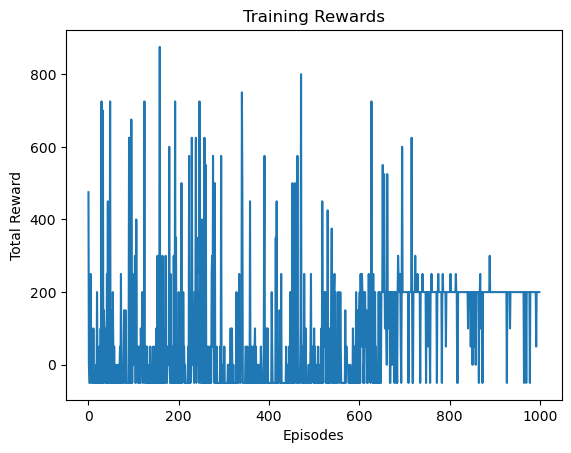

In [13]:
# Plot Rewards

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards')
    plt.show()

plot_rewards(rewards_history)


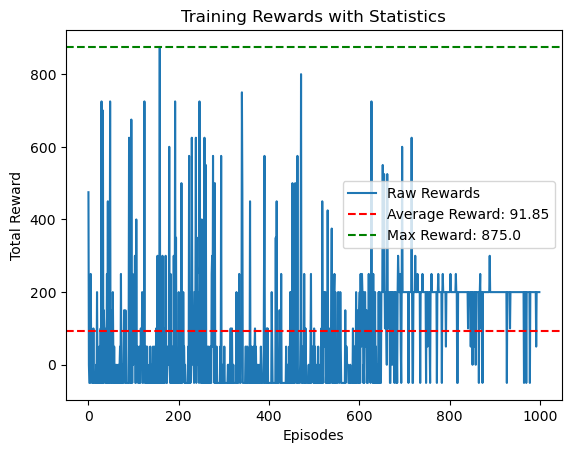

In [14]:
# More Stats

average_reward = np.mean(rewards_history)
max_reward = np.max(rewards_history)

plt.plot(rewards_history, label="Raw Rewards")
plt.axhline(average_reward, color='r', linestyle='--', label=f"Average Reward: {average_reward:.2f}")
plt.axhline(max_reward, color='g', linestyle='--', label=f"Max Reward: {max_reward}")
plt.title("Training Rewards with Statistics")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()
plt.show()


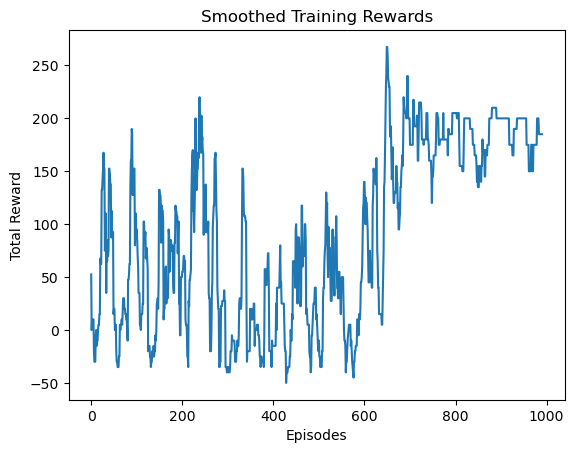

In [15]:
# Even More Stats

window = 10
smoothed_rewards = np.convolve(rewards_history, np.ones(window)/window, mode='valid')

plt.plot(smoothed_rewards)
plt.title("Smoothed Training Rewards")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()


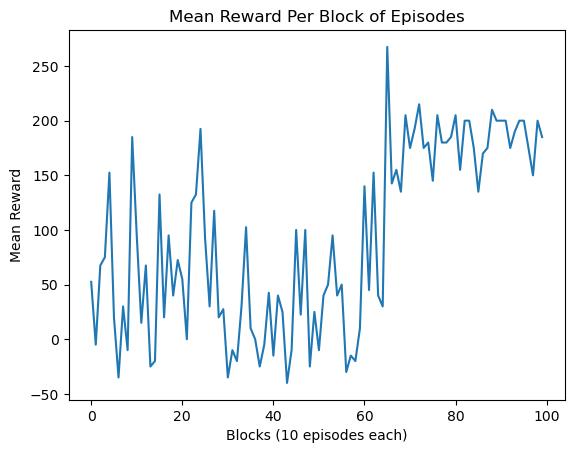

In [16]:
# Yet Another Stats Block

block_size = 10
block_means = [np.mean(rewards_history[i:i+block_size]) for i in range(0, len(rewards_history), block_size)]

plt.plot(block_means)
plt.title("Mean Reward Per Block of Episodes")
plt.xlabel("Blocks (10 episodes each)")
plt.ylabel("Mean Reward")
plt.show()


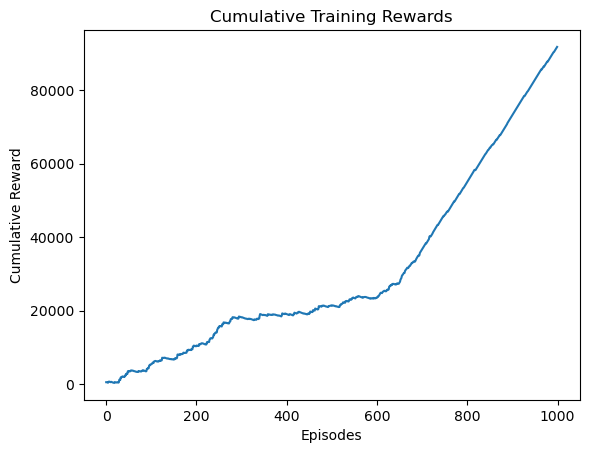

In [17]:
# Actually the Last Stats Block

cumulative_rewards = np.cumsum(rewards_history)

plt.plot(cumulative_rewards)
plt.title("Cumulative Training Rewards")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()
